# Week 6 - Discovering Patterns: Clusters & Topics

In [3]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).


# ***What?*** 
<200 words

Our final project intends to understand the mechanisms of how people vote on Reddit. Reddit is a network of communities based on people's interests, and the discussion runs on the principle of vote aggregation. Each user can give a post an upvote of approval or a downvote of disapproval. The system ensures that highly ranked posts rise to the top of the site, and highly ranked comments rise to the top of their threads. We intend to compare the texts and contexts of high-ranking and low-ranking comments and explore their relationship to that of their parent comments.

## ***Why?***
<200 words

People in online interactions show approval through verbal (e.g. comments) and symbolic (e.g. likes, emojis) feedback. On many social media platforms, e.g. Facebook, people like each other's posts out of social needs or reciprocity drives. However, on Reddit, people use upvotes and downvotes only to lead conversations on political and social opinions. The highly ranked posts and comments often influence or even change the decisions of how viewers might also vote. Some research has shown that people are more likely to go along with positive opinions but are more skeptical of the negative opinions of others. We would like to see if that happens in the upvote and downvote system in the community.

## ***How?***
<400 words

We will investigate four factors in our dataset -- comment, upvotes/downvotes of comment, parent comment, upvotes/downvotes of parent comment, and explore their relationships with each other. First, we will focus on the comment itself and explore several questions: what makes a comment receive upvotes/downvotes? We will look at and compare the sentence structure, sentiment, and embedded topics in the two types of comments. Then, we will examine the relationship between comments and their parent comments based on their texts and scores (upvotes/downvotes). What are the similarities in their structure and topics? Are people more likely to upvote positive responses to the parent comments or skeptical ones? These are all interesting questions we intend to answer.

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).

## ***Which (words)?***
<300 words

We downloaded a sample dataset on Kaggle. The dataset comes from pushshift.io, and is a subset of a much larger dataset of 380+ million reddit comments. This dataset contains 4 million of the reddit comments, 2 million of which are the lowest scored (highly downvoted), and 2 million of which are the highest scored (highly upvoted). All comments come along with their parent comments.

This dataset is pretty sufficient for exploratory analysis. However, there might be two limitations in our dataset. First, since the dataset is uploaded in 2018 and Reddit activities are changing in real time, we may not be able to observe the most recent scores of these comments. Our analysis is based on the information these websites gathered in 2018. Second, while it provides comments and parent comments for each observation, it does not include the thread these comments are responding to. The contexts of the thread can be an important factor in determining the upvotes/downvotes of comments.

Therefore, if we find interesting patterns in this dataset, we can scale up our sample by scraping the Reddit website to obtain the thread of the comments (possibly based on author and comment id) and their most recent upvotes/downvotes.

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

## Getting the dataset

In [53]:
# The positive dataset contains 2 million of comments that are the highest scored (highly upvoted). My teammate works
# on the other dataset that contains the lowest scored comments. The dataset is arranged in the order of 
# decreasing scores and I'll first consider the top 5000 comments.

commentsPosDF = pandas.read_csv("comments_positive.csv", nrows = 5000)
commentsPosDF.head()

,id,parent_id,subreddit_id,link_id,text,score,ups,author,controversiality,parent_link_id,parent_text,parent_score,parent_ups,parent_author,parent_controversiality
0,c092j8m,t1_c092gss,t5_2qh2p,t3_8eyy3,This isn't Twitter: try to comment on the arti...,9582,9582,nraustinii,0,t3_8eyy3,Fucking faggot.,-7526,-7526,Glorificus,0
1,c4imcva,t1_c4im948,t5_2qh1i,t3_t0ynr,"Well, it is exactly what it sounds like. It's ...",9531,9531,Lynfect,0,t3_t0ynr,"Elaborate on this cum box, please.",3841,3841,eeeeevil,0
2,c0s4nfi,t1_c0s4lje,t5_2qh1i,t3_cf1n2,"In soviet Russia, bomb disarms you!",8545,8545,CapnScumbone,0,t3_cf1n2,"I don't live in Russia anymore, and I will not...",621,621,shady8x,0
3,c4ini33,t1_c4incln,t5_2qh1i,t3_t0ynr,"""runin for senitur! #YOLO!""",7430,7430,[deleted],0,t3_t0ynr,This just made me realize that future presiden...,4651,4651,drspg99,0
4,c4imgel,t1_c4ima2e,t5_2qh1i,t3_t0ynr,You step motherfucker.,7173,7173,jbg89,0,t3_t0ynr,I have sex with my step mom when my dad isn't ...,4251,4251,audir8,0


In [54]:
commentsPosDF = commentsPosDF.dropna(axis=0, how='any')

In [55]:
CountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
commentsVects = CountVectorizer.fit_transform(commentsPosDF['text'])
print(commentsVects.shape)

(5000, 16298)


In [56]:
TFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(commentsVects)
commentsTF = TFTransformer.transform(commentsVects)
print(commentsTF.shape)

(5000, 16298)


In [57]:
list(zip(CountVectorizer.vocabulary_.keys(), commentsTF.data))[:20]

[('this', 0.17350274312913982),
 ('isn', 0.4134904217720789),
 ('twitter', 0.2765007817081506),
 ('try', 0.11674644223654967),
 ('to', 0.15262635918420595),
 ('comment', 0.10246813805721104),
 ('on', 0.16099002925443373),
 ('the', 0.17264270094906234),
 ('article', 0.2734145623257598),
 ('and', 0.3683442237437197),
 ('not', 0.2510718075804415),
 ('your', 0.36503341919319654),
 ('current', 0.12418012149504093),
 ('activities', 0.44405190721690757),
 ('well', 0.06448345568248412),
 ('it', 0.06586655044636464),
 ('is', 0.025711232561135847),
 ('exactly', 0.04519846107398552),
 ('what', 0.02183471660831994),
 ('sounds', 0.029113232470831914)]

In [58]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.50, max_features=1000, min_df=3, stop_words='english', norm='l2')
commentsTFVects = TFVectorizer.fit_transform(commentsPosDF['text'])

In [59]:
commentsPosDF['text']

0       This isn't Twitter: try to comment on the arti...
1       Well, it is exactly what it sounds like. It's ...
2                     In soviet Russia, bomb disarms you!
3                             "runin for senitur! #YOLO!"
4                                  You step motherfucker.
5        Isn't this putting Descartes before the whores? 
6                                           WHAT THE FUCK
7                    because i'm serious about my dancing
8       Dude. This is bad news.\n\nI'm not being all m...
9       I also find it ironic that 72 virgins are atta...
10                          Worst. Money launderer. Ever.
11                                          call me maybe
12                                      So do some girls 
13                                                     :)
14      A quarter for air?!\n\nWell, I guess that's in...
15                                  The cake. It's a lie.
16      This is literally the juciest secret in this t...
17      **Jenn

In [60]:
list(TFVectorizer.vocabulary_.keys())[10:20]

['ve',
 'years',
 'think',
 'fair',
 'tried',
 'simply',
 'didn',
 'actually',
 'turns',
 'body']

## Flat Clustering with $K$-means

In [61]:
numClusters = 5

In [62]:
comment_km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

In [63]:
comment_km.fit(commentsTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [65]:
commentsPosDF['kmeans_predictions'] = comment_km.labels_
commentsPosDF.head()

,id,parent_id,subreddit_id,link_id,text,score,ups,author,controversiality,parent_link_id,parent_text,parent_score,parent_ups,parent_author,parent_controversiality,kmeans_predictions
0,c092j8m,t1_c092gss,t5_2qh2p,t3_8eyy3,This isn't Twitter: try to comment on the arti...,9582,9582,nraustinii,0,t3_8eyy3,Fucking faggot.,-7526,-7526,Glorificus,0,1
1,c4imcva,t1_c4im948,t5_2qh1i,t3_t0ynr,"Well, it is exactly what it sounds like. It's ...",9531,9531,Lynfect,0,t3_t0ynr,"Elaborate on this cum box, please.",3841,3841,eeeeevil,0,3
2,c0s4nfi,t1_c0s4lje,t5_2qh1i,t3_cf1n2,"In soviet Russia, bomb disarms you!",8545,8545,CapnScumbone,0,t3_cf1n2,"I don't live in Russia anymore, and I will not...",621,621,shady8x,0,1
3,c4ini33,t1_c4incln,t5_2qh1i,t3_t0ynr,"""runin for senitur! #YOLO!""",7430,7430,[deleted],0,t3_t0ynr,This just made me realize that future presiden...,4651,4651,drspg99,0,1
4,c4imgel,t1_c4ima2e,t5_2qh1i,t3_t0ynr,You step motherfucker.,7173,7173,jbg89,0,t3_t0ynr,I have sex with my step mom when my dad isn't ...,4251,4251,audir8,0,1


In [66]:
terms = TFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = comment_km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 http
 com
 edit
 gold
 imgur
 thanks
 jpg
 thank
 gif
 stranger


Cluster 1:
 fucking
 fuck
 got
 guy
 yes
 good
 time
 did
 man
 right


Cluster 2:
 gt
 like
 nice
 just
 ve
 time
 did
 old
 baby
 edit


Cluster 3:
 just
 don
 people
 know
 think
 time
 edit
 want
 like
 ll


Cluster 4:
 like
 just
 sounds
 looks
 really
 feel
 look
 don
 people
 actually




In [67]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(commentsTFVects.toarray())
reduced_data = pca.transform(commentsTFVects.toarray())

In [68]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:5].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

In [69]:
colordict = {0: 'plum', 1: 'lavender', 2: 'olive', 3: 'lightgreen', 4: 'lightblue', 5: 'coral'}
colors = [colordict[c] for c in commentsPosDF['kmeans_predictions']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([(0, 'plum'), (1, 'lavender'), (2, 'olive'), (3, 'lightgreen'), (4, 'lightblue'), (5, 'coral')])


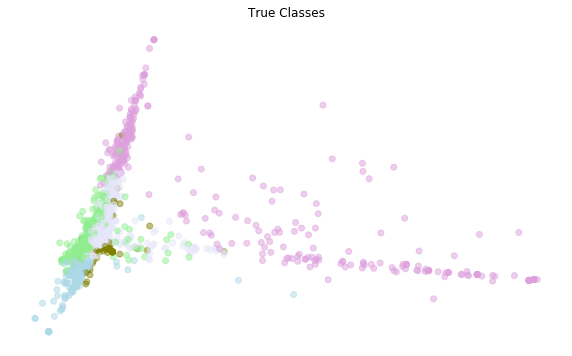

In [70]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

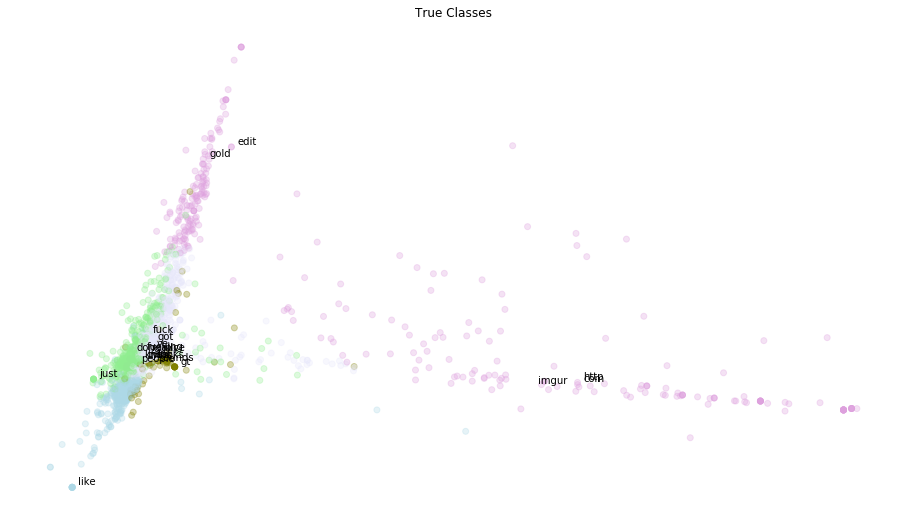

In [71]:
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

## parent comment
Here, I applied the same k-means clustering to the parent comments. I constructed a new dataframe called sameDF that only includes comments and parent comments which are predicted to be in the same cluster. I would like to see whether there were a cleared pattern in these clusters.

In [22]:
parCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
parentVects = parCountVectorizer.fit_transform(commentsPosDF['parent_text'])

In [23]:
parTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(parentVects)
parentTF = parTFTransformer.transform(parentVects)

In [24]:
parTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.50, max_features=1000, min_df=3, stop_words='english', norm='l2')
parentTFVects = parTFVectorizer.fit_transform(commentsPosDF['parent_text'])

In [25]:
parent_km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
parent_km.fit(parentTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [26]:
commentsPosDF['parent_predictions'] = parent_km.labels_

## sameDF

In [27]:
sameDF = commentsPosDF[commentsPosDF.kmeans_predictions == commentsPosDF.parent_predictions]
sameDF.head()

,id,parent_id,subreddit_id,link_id,text,score,ups,author,controversiality,parent_link_id,parent_text,parent_score,parent_ups,parent_author,parent_controversiality,kmeans_predictions,parent_predictions
41,codcbu3,t1_codatig,t5_2qh33,t3_2v06c0,They need to know what bow shot the arrow to k...,5005,5005,ddrddrddrddr,0,t3_2v06c0,Why does the kid have the bow in the hospital.,3933,3933,Jamesaki,0,4,4
47,cnfqeii,t1_cnfpq4s,t5_2qzb6,t3_2rgsan,It won't look like other cars,4911,4911,ElonMuskOfficial,0,t3_2rgsan,"Hi Elon, I'm already saving up for my Model 3....",3652,3652,StapleGun,0,2,2
59,cp80bwq,t1_cp7yr3d,t5_2qh1i,t3_2yasst,If you cant handle me at my didliest then you ...,4836,4836,drewtoli,0,t3_2yasst,That ruined the flanders dynamic for me too,2294,2294,ChicagoRunner,0,4,4
63,cnyitrn,t1_cnyf7pm,t5_2qh1i,t3_2tejm0,"She just gave him a kiss on the cheek, no need...",4804,4804,Macrat,0,t3_2tejm0,Are you the guy who's been fucking my mom?!,3750,3750,MethMouthMagoo,0,4,4
65,cpa7a5p,t1_cpa5q31,t5_2qh1i,t3_2yjqwo,2 Cold 2 War\n\nEdit: Wow. 2 Thank 2 You for t...,4780,4780,jakehightower,0,t3_2yjqwo,Second Cold War: Even Colder.\n\nOn a more ser...,4367,4367,assesundermonocles,0,4,4


In [28]:
sameDF['kmeans_predictions'].value_counts()

4    161
2     77
0     75
3     36
1     10
Name: kmeans_predictions, dtype: int64

Reduce the number of clusters to 3 to prevent imbalanced dataset.

In [29]:
sameCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
same_comVects = sameCountVectorizer.fit_transform(sameDF['text'])

In [30]:
sameTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(same_comVects)
same_comTF = sameTFTransformer.transform(same_comVects)

In [31]:
sameTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.50, max_features=1000, min_df=3, stop_words='english', norm='l2')
same_comTFVects = sameTFVectorizer.fit_transform(sameDF['text'])

In [32]:
same_km = sklearn.cluster.KMeans(n_clusters=3, init='k-means++')
same_km.fit(same_comTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [33]:
sameDF['kmeans_predictions'] = same_km.labels_

/Users/reneehu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
same_terms = sameTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = same_km.cluster_centers_.argsort()[:, ::-1]
for i in range(3):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % same_terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 like
 just
 don
 people
 sounds
 com
 sure
 reddit
 http
 did


Cluster 1:
 thanks
 gold
 edit
 stranger
 kind
 reddit
 man
 day
 comment
 obligatory


Cluster 2:
 edit
 thank
 gold
 comment
 stranger
 kind
 wow
 redditor
 just
 really




In [35]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(same_comTFVects.toarray())
reduced_data = pca.transform(same_comTFVects.toarray())

In [36]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:5].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [same_terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

In [37]:
colordict = {0: 'plum', 1: 'coral', 2: 'olive'}
colors = [colordict[c] for c in sameDF['kmeans_predictions']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([(0, 'plum'), (1, 'coral'), (2, 'olive')])


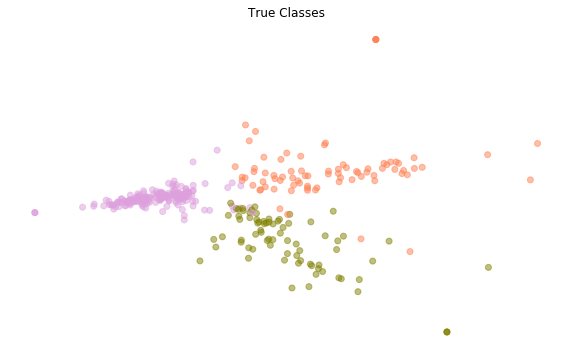

In [38]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

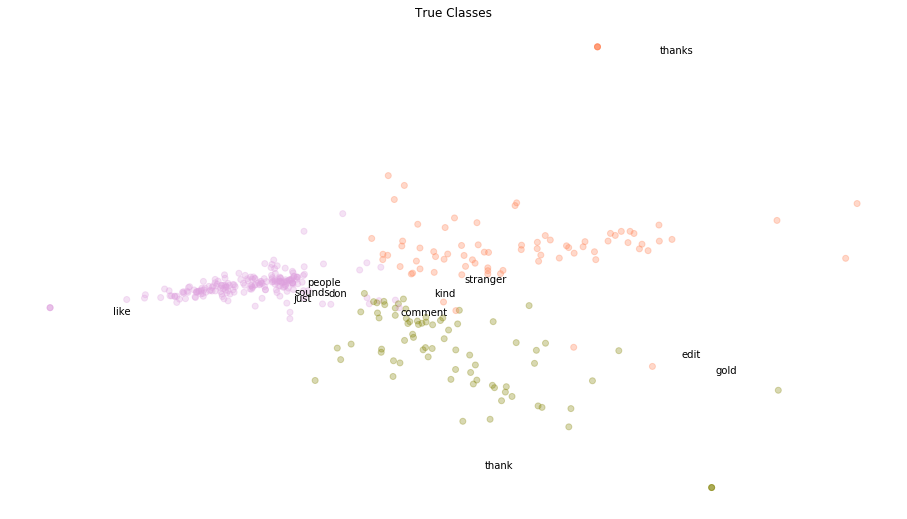

In [39]:
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

In [40]:
same_parVects = sameCountVectorizer.fit_transform(sameDF['parent_text'])
sameTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(same_parVects)
same_parTF = sameTFTransformer.transform(same_parVects)
same_parTFVects = sameTFVectorizer.fit_transform(sameDF['parent_text'])

In [41]:
same_km.fit(same_parTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [42]:
sameDF['parent_predictions'] = same_km.labels_

/Users/reneehu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [43]:
same_terms = sameTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = same_km.cluster_centers_.argsort()[:, ::-1]
for i in range(3):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % same_terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 www
 youtube
 watch
 com
 https
 http
 proof
 15
 op
 video


Cluster 1:
 com
 imgur
 http
 jpg
 gif
 gifv
 nsfw
 old
 plane
 right


Cluster 2:
 like
 don
 edit
 people
 just
 did
 http
 really
 going
 com




In [44]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(same_parTFVects.toarray())
reduced_data = pca.transform(same_parTFVects.toarray())
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [same_terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

In [45]:
colordict = {0: 'plum', 1: 'coral', 2: 'olive'}
colors = [colordict[c] for c in sameDF['parent_predictions']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([(0, 'plum'), (1, 'coral'), (2, 'olive')])


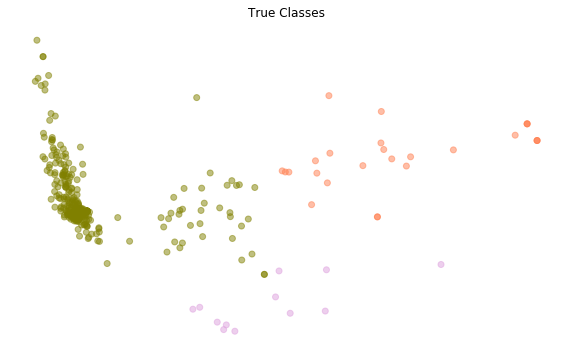

In [46]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

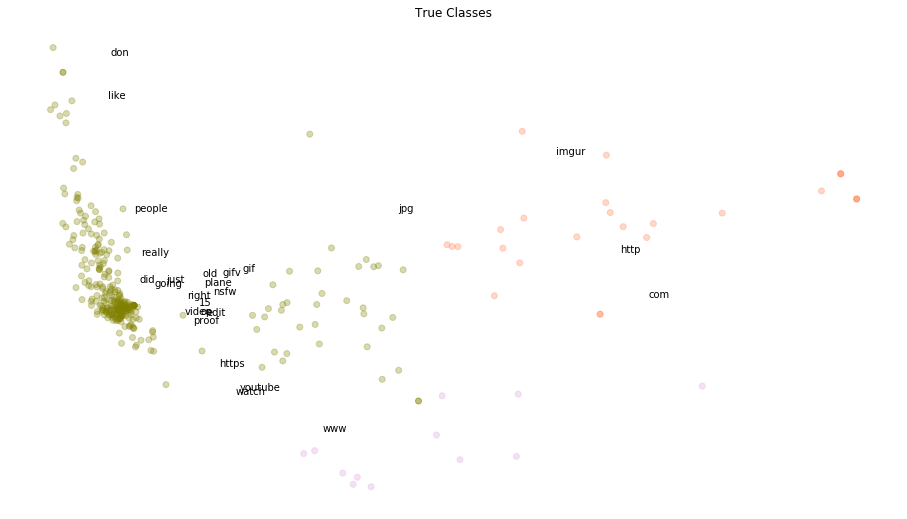

In [47]:
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

The clusters showed a clearer pattern of words and the visualizations suggested a better separation of clusters. The topics are similar to what we observed in the original dataset.

## Selecting Cluster Number
The following analysis is still based on the original dataset.

In [48]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


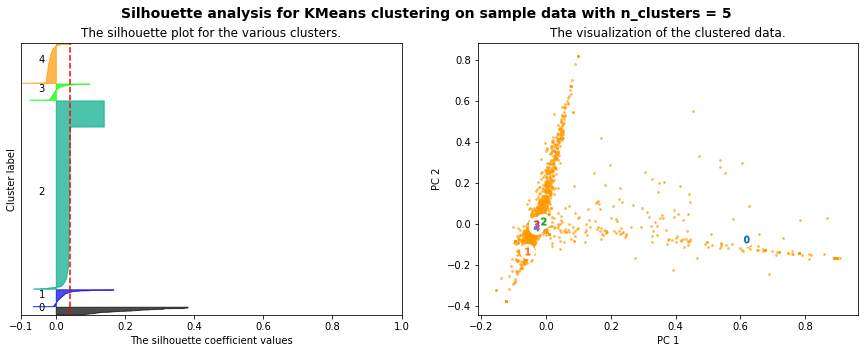

For n_clusters = 5, The average silhouette_score is : 0.041


In [72]:
X = commentsTFVects.toarray()
plotSilhouette(5, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


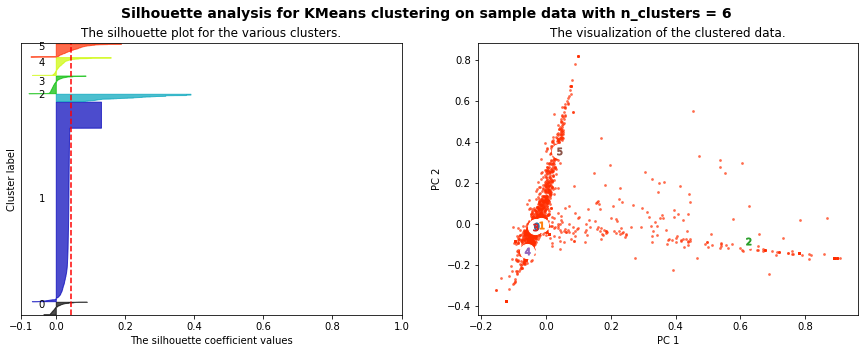

For n_clusters = 6, The average silhouette_score is : 0.044


In [73]:
X = commentsTFVects.toarray()
plotSilhouette(6, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


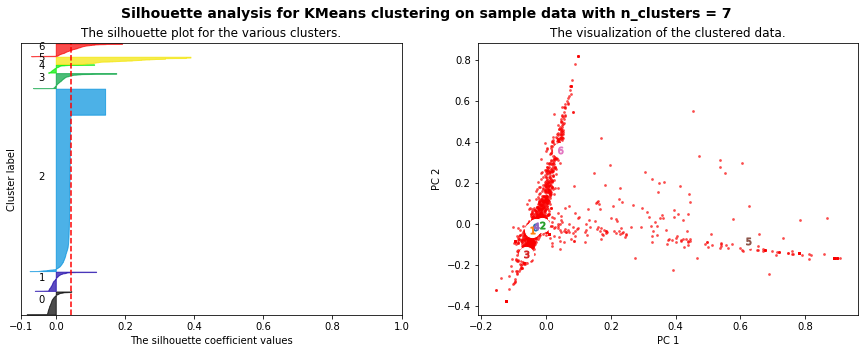

For n_clusters = 7, The average silhouette_score is : 0.044


In [74]:
X = commentsTFVects.toarray()
plotSilhouette(7, X)

The silhoutte scores above suggest that 6 is a reasonable number of clusters.

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

In [75]:
commentsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.07625322, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [76]:
commentsCoocMat = commentsTFVects * commentsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
commentsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


/Users/reneehu/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [77]:
selectIndices = []
indexToCat = []
for c in set(commentsPosDF['kmeans_predictions']):
    selectIndices += list(commentsPosDF[commentsPosDF['kmeans_predictions'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [79]:
subCoocMat = commentsCoocMat[selectIndices,:][:,selectIndices]

In [80]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/Users/reneehu/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[ 51.,  52.,   0.,   2.],
       [ 53., 250.,   0.,   3.],
       [ 56., 251.,   0.,   4.],
       [ 58., 252.,   0.,   5.],
       [ 62., 253.,   0.,   6.],
       [ 67., 254.,   0.,   7.],
       [ 68., 255.,   0.,   8.],
       [ 72., 256.,   0.,   9.],
       [ 82., 257.,   0.,  10.],
       [ 84., 258.,   0.,  11.]])

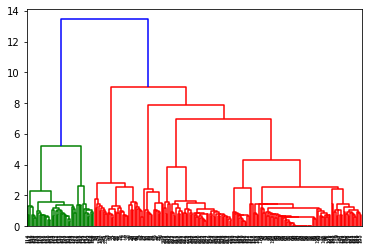

In [81]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

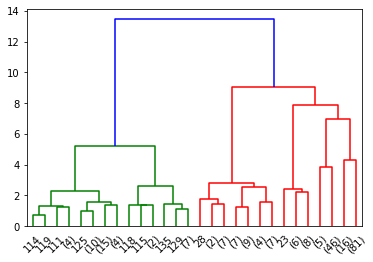

In [82]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

The hierarchical clustering suggested that our comments are similar to each other based on the number of shared words.

In [83]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 6, 'maxclust')

In [84]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(commentsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 6, 'maxclust')

In [85]:
commentsPosDF['wald_predictions'] = hierarchicalClusters_full
commentsPosDF.head()

,id,parent_id,subreddit_id,link_id,text,score,ups,author,controversiality,parent_link_id,parent_text,parent_score,parent_ups,parent_author,parent_controversiality,kmeans_predictions,wald_predictions
0,c092j8m,t1_c092gss,t5_2qh2p,t3_8eyy3,This isn't Twitter: try to comment on the arti...,9582,9582,nraustinii,0,t3_8eyy3,Fucking faggot.,-7526,-7526,Glorificus,0,1,6
1,c4imcva,t1_c4im948,t5_2qh1i,t3_t0ynr,"Well, it is exactly what it sounds like. It's ...",9531,9531,Lynfect,0,t3_t0ynr,"Elaborate on this cum box, please.",3841,3841,eeeeevil,0,3,4
2,c0s4nfi,t1_c0s4lje,t5_2qh1i,t3_cf1n2,"In soviet Russia, bomb disarms you!",8545,8545,CapnScumbone,0,t3_cf1n2,"I don't live in Russia anymore, and I will not...",621,621,shady8x,0,1,6
3,c4ini33,t1_c4incln,t5_2qh1i,t3_t0ynr,"""runin for senitur! #YOLO!""",7430,7430,[deleted],0,t3_t0ynr,This just made me realize that future presiden...,4651,4651,drspg99,0,1,6
4,c4imgel,t1_c4ima2e,t5_2qh1i,t3_t0ynr,You step motherfucker.,7173,7173,jbg89,0,t3_t0ynr,I have sex with my step mom when my dad isn't ...,4251,4251,audir8,0,1,6


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

## Gensim

In [86]:
commentsPosDF['tokenized_text'] = commentsPosDF['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
commentsPosDF['normalized_tokens'] = commentsPosDF['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [87]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]
commentsPosDF['reduced_tokens'] = commentsPosDF['normalized_tokens'].apply(lambda x: dropMissing(x, TFVectorizer.vocabulary_.keys()))

In [88]:
dictionary = gensim.corpora.Dictionary(commentsPosDF['reduced_tokens'])

In [89]:
corpus = [dictionary.doc2bow(text) for text in commentsPosDF['reduced_tokens']]

In [90]:
gensim.corpora.MmCorpus.serialize('comments', corpus)
comments = gensim.corpora.MmCorpus('comments')

In [91]:
commentslda = gensim.models.ldamodel.LdaModel(corpus=comments, id2word=dictionary, num_topics=6, alpha='auto', eta=0.8)

In [92]:
comments1Bow = dictionary.doc2bow(commentsPosDF['reduced_tokens'][0])
comments1lda = commentslda[comments1Bow]
print("The score of the text: {}".format(commentsPosDF['score'][0]))
print("are: {}".format(comments1lda))

The score of the text: 9582
are: [(0, 0.020248704), (1, 0.024723483), (2, 0.023849025), (3, 0.885607), (4, 0.021933477), (5, 0.023638278)]


Construct the dataframe on the score of the comments (upvotes) and the topics generated by LDA model

In [93]:
ldaDF = pandas.DataFrame({
        'score' : commentsPosDF['score'],
        'topics' : [commentslda[dictionary.doc2bow(l)] for l in commentsPosDF['reduced_tokens']]
    })

In [94]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(commentslda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(commentslda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF.head()

,score,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
0,9582,"[(0, 0.020248814), (1, 0.02472349), (2, 0.0238...",0.020249,0.024723,0.023849,0.885607,0.021933,0.023638
1,9531,"[(1, 0.99221444)]",0.000000,0.992214,0.000000,0.000000,0.000000,0.000000
2,8545,"[(0, 0.14517972), (1, 0.17698033), (2, 0.17075...",0.145180,0.176980,0.170755,0.180527,0.157318,0.169240
3,7430,"[(0, 0.14517972), (1, 0.17698033), (2, 0.17075...",0.145180,0.176980,0.170755,0.180527,0.157318,0.169240
4,7173,"[(0, 0.064943925), (1, 0.63149613), (2, 0.0764...",0.064944,0.631496,0.076439,0.080843,0.070404,0.075874


In [95]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(6)]]
ldaDFVisN = ldaDF[:10][['score']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
0,0.020249,0.024723,0.023849,0.885607,0.021933,0.023638
1,0.000000,0.992214,0.000000,0.000000,0.000000,0.000000
2,0.145180,0.176980,0.170755,0.180527,0.157318,0.169240
3,0.145180,0.176980,0.170755,0.180527,0.157318,0.169240
4,0.064944,0.631496,0.076439,0.080843,0.070404,0.075874
5,0.145180,0.176980,0.170755,0.180527,0.157318,0.169240
6,0.064957,0.079279,0.076463,0.633011,0.070451,0.075839
7,0.145180,0.176980,0.170755,0.180527,0.157318,0.169240
8,0.000000,0.000000,0.550854,0.000000,0.425235,0.000000
9,0.064958,0.630899,0.076733,0.081242,0.070407,0.075761


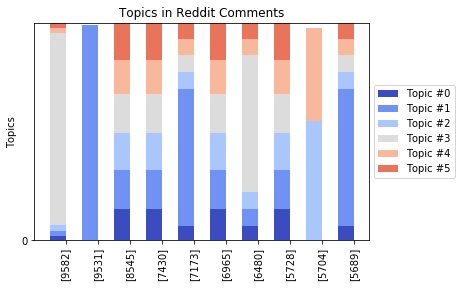

In [96]:
N = 10
ind = np.arange(N)
K = commentslda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Reddit Comments')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

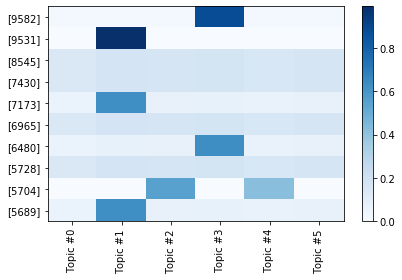

In [97]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [99]:
commentslda.show_topic(1)

[('people', 0.029423205),
 ('good', 0.015707096),
 ('know', 0.0146988565),
 ('yes', 0.013680364),
 ('feel', 0.011789451),
 ('think', 0.011541299),
 ('edit', 0.011392473),
 ('like', 0.011347312),
 ('want', 0.010503824),
 ('leave', 0.0099102305)]

In [100]:
topicsDict = {}
for topicNum in range(commentslda.num_topics):
    topicWords = [w for w, p in commentslda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,think,people,like,edit,tell,time
1,kid,good,know,thank,guy,like
2,pizza,know,edit,say,thor,think
3,want,yes,say,fuck,man,come
4,people,feel,think,gold,want,people
5,time,think,black,time,day,thing
6,like,edit,look,know,come,look
7,know,like,love,day,know,way
8,white,want,woman,guy,like,year
9,write,leave,man,friend,time,want


<Figure size 432x288 with 0 Axes>

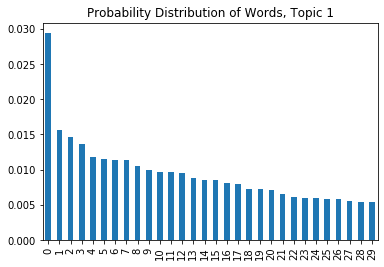

In [101]:
topic1_df = pandas.DataFrame(commentslda.show_topic(1, topn=30))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

In [102]:
commentslda1 = gensim.models.ldamodel.LdaModel(corpus=comments, id2word=dictionary, num_topics=6, eta = 0.00001)
commentslda2 = gensim.models.ldamodel.LdaModel(corpus=comments, id2word=dictionary, num_topics=6, eta = 0.9)

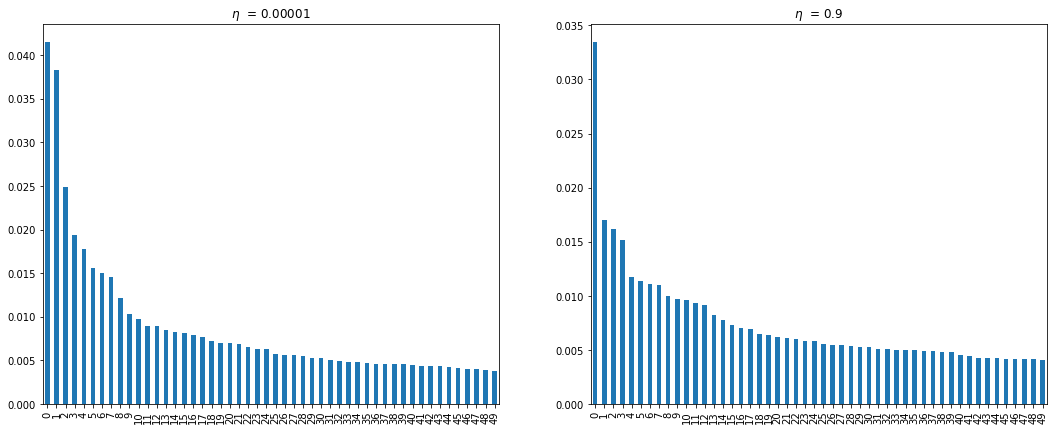

In [103]:
topic11_df = pandas.DataFrame(commentslda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(commentslda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

The LDA model doesn't work well on our dataset mainly out of two reasons. First, Reddit comments are by nature very short; after reducing the tokens, there weren't many words left for LDA model. Second, the comments do not have a coherent topic but are gathered from different communities. Therefore, the topics generated by LDA model are not intuitive and consist of many repetitive words. Since we only have one document, we won't be able to use topic loadings as another feature on our clusters.

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

In my last HW, I have shown that our dataset does not provide much information about networks of relationships. In addition, since Reddit comments are short in nature, training LDA model does not produce intuitive topics. Therefore, I'll perform a similar analysis on the SOAP corpora and extract topic distributions on different datasets.

In [104]:
corpora_address = "/Users/reneehu/Desktop/SOAP"
soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=2000)

text_7-jss.zip
text_6-egn.zip
text_5-rag.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_8-sbo.zip
text_9-jtw.zip
text_0-tez.zip
text_1-teh.zip


In [105]:
import zipfile
import pandas as pd

In [106]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [107]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [108]:
soap_dict = {}

In [109]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [110]:
soap_dict.keys()

dict_keys(['All My Childen', 'As the World Turns', 'Bold and Beautiful', 'Days of Our Lives', 'General Hospital', 'Guiding Light', 'One Life to Live', 'Passions', 'Port Charles', 'Young and Restless'])

In [111]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [112]:
i = 0
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


In [113]:
dool = soap_df['Tokenized Texts'][2]

In [114]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [115]:
import networkx as nx

In [116]:
actor_network = nx.Graph()

In [117]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [118]:
i = 0
all_texts = []
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud_2020.normalizeTokens(dool[i:j]))

/Users/reneehu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


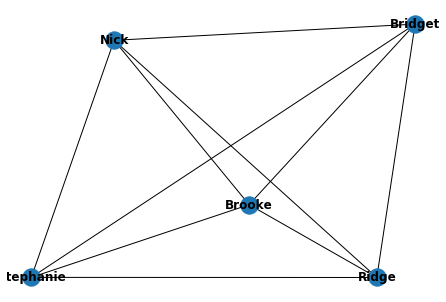

In [119]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

In [120]:
all_texts[0:10]

[[],
 ['want', 'marry'],
 ['answer', 'phone', 'probably', 'home'],
 ['yes',
  'believe',
  'time',
  'confide',
  'mystery',
  'man',
  'wonderful',
  'time',
  'deacon'],
 ['oh',
  'honey',
  'easy',
  'teenager',
  'love',
  'think',
  'know',
  'deacon',
  'well',
  'hear',
  'misunderstand'],
 ['have', 'see', 'come'],
 ['warn', 'office'],
 ['gon', 'na', 'devastate', 'brooke', 'realize'],
 ['okay'],
 ['ready', 'let']]

In [121]:
dictionary = gensim.corpora.Dictionary(all_texts)
corpus = [dictionary.doc2bow(text) for text in all_texts]
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, 
                                          num_topics=6, alpha='auto', eta='auto', 
                                          iterations=400, eval_every = None, passes=4)
doollda.show_topics()

[(0,
  '0.044*"get" + 0.035*"tell" + 0.028*"have" + 0.028*"talk" + 0.025*"need" + 0.022*"want" + 0.022*"know" + 0.019*"hope" + 0.018*"thing" + 0.018*"happen"'),
 (1,
  '0.057*"know" + 0.037*"yes" + 0.034*"go" + 0.021*"want" + 0.021*"be" + 0.021*"love" + 0.015*"have" + 0.015*"think" + 0.015*"like" + 0.012*"ridge"'),
 (2,
  '0.058*"okay" + 0.042*"good" + 0.039*"want" + 0.024*"wait" + 0.021*"mm" + 0.020*"come" + 0.019*"ridge" + 0.018*"taylor" + 0.017*"let" + 0.016*"hmm"'),
 (3,
  '0.098*"oh" + 0.072*"be" + 0.067*"na" + 0.066*"gon" + 0.029*"steffy" + 0.026*"uh" + 0.025*"sorry" + 0.025*"god" + 0.023*"honey" + 0.016*"hello"'),
 (4,
  '0.056*"think" + 0.055*"right" + 0.023*"stop" + 0.023*"be" + 0.020*"hey" + 0.018*"great" + 0.016*"course" + 0.014*"katie" + 0.013*"fine" + 0.012*"help"'),
 (5,
  '0.052*"mother" + 0.048*"thank" + 0.036*"like" + 0.027*"say" + 0.018*"sure" + 0.015*"nick" + 0.014*"wrong" + 0.012*"pam" + 0.012*"door" + 0.011*"owen"')]

In [122]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]
for actor in actor_network.nodes():
    print(actor_network.nodes[actor]['topic_distribution'])

[(0, 0.11272835), (2, 0.5028977), (4, 0.2536617), (5, 0.1299155)]
[(0, 0.11405213), (2, 0.5052698), (4, 0.24969646), (5, 0.13097794)]
[(0, 0.11360248), (2, 0.500496), (4, 0.24845026), (5, 0.1374465)]
[(0, 0.10938968), (2, 0.5095264), (4, 0.25060275), (5, 0.13047644)]
[(0, 0.106863916), (2, 0.50551486), (4, 0.25506675), (5, 0.132548)]


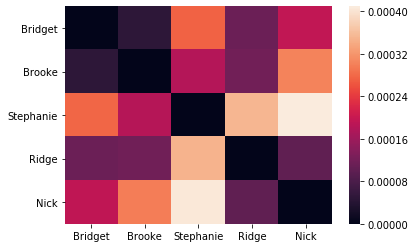

In [123]:
from gensim.matutils import kullback_leibler
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

Here I extended the analysis on another soap opera "Bold and Beautiful". There are fewer characters in the network, so it's harder to analyze the topics in the dataset. Although the topics are not very informative, we can infer that it might be a love story from the positive sentiments and keywords such as "love" and "honey". The heatmap suggests that the characters have different patterns of speaking in terms of topics. Ridge shared a lot of similarities with other characters, including Bridget and Brooke. Ridge might be the main character in the show. Stephanie's topics are divergent from those of other characters. She might be a less important character or might have a very different identity.